In [31]:
%load_ext autoreload
%autoreload 2
import os
import shutil
if not os.path.exists('configs'): get_ipython().run_line_magic('cd', '..')

from utils import plot_utils as putils
custom_color_dict = putils.set_matplotlib_params()

from preprocessing.preprocessing_utils import Backup, get_data_paths, get_figure_path
asset_path, data_path = get_data_paths('./configs')
figure_path = get_figure_path('./configs')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
# Standard library imports
from pathlib import Path
from datetime import datetime
import json
import pickle
from collections import defaultdict

# Data handling and preprocessing
import pandas as pd
import numpy as np

# Geospatial data handling
import cartopy.crs as ccrs

# Visualization
import matplotlib.pyplot as plt

# Parallel processing
from multiprocessing import Pool

import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib import cm


In [33]:
cat_c = ['darkorange', 'crimson', 'indigo', 'dodgerblue']

# 여러 해의 데이터를 읽고 concat하여 고유한 'num' 값만 남기기
pos = pd.concat(
    pd.read_csv(Path(figure_path, 'region', f'region_data_{year}.csv'))
    for year in [2020, 2021, 2022]
).drop_duplicates(subset=['num'])

# 'year' 컬럼 삭제하고 'cat' 컬럼 생성
pos = pos.drop(columns=['year'])
pos = pos.rename(columns={'priority': 'cat'})
pos = pos.sort_values(by='num').reset_index(drop=True)
pos.head()

,num,lon,lat,cat
0,4821,126.544771,33.273132,3
1,5565,126.491969,33.501242,3
2,5566,126.546631,33.500946,3
3,5567,126.601292,33.500620,3
4,8994,126.610883,34.550807,3


In [34]:
output_path_1 = Path('./output/with_units/24-7-25/9-15-1')
output_path_2 = Path('./output/without_units/24-7-25/9-15-6')

feature_importance_1 = pd.read_csv(Path(output_path_1, 'feature_importances.csv'))
feature_importance_2 = pd.read_csv(Path(output_path_2, 'feature_importances.csv'))

feature_importance_1 = feature_importance_1.rename(columns={'Unnamed: 0': 'feature'})
feature_importance_2 = feature_importance_2.rename(columns={'Unnamed: 0': 'feature'})

feature_names = feature_importance_1['feature'].values

In [155]:
feature_importance_1.head()

,feature,val_year:2020|gain,val_year:2020|total_gain,val_year:2020|weight,val_year:2021|gain,val_year:2021|total_gain,val_year:2021|weight,val_year:2022|gain,val_year:2022|total_gain,val_year:2022|weight
0,district_c0,16.484072,65474.730469,3972.0,10.088846,8.169948e+04,8098.0,10.739768,8.738949e+04,8137.0
1,district_c1,11.526513,86483.429688,7503.0,6.963169,1.082912e+05,15552.0,6.414875,1.015282e+05,15827.0
2,district_c2,9.376346,91156.828125,9722.0,5.249782,1.079355e+05,20560.0,5.517691,1.268572e+05,22991.0
3,district_c3,13.040716,80448.179688,6169.0,6.698897,8.651626e+04,12915.0,7.749554,1.173670e+05,15145.0
4,units_qt,14.687875,863221.062500,58771.0,7.700241,1.127030e+06,146363.0,7.122293,1.139374e+06,159973.0


___

In [306]:
cmap=plt.cm.inferno
vmin=0.3
vmax=4.3
goodwhite = 'snow'

norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm_log = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm_log.set_array([])
climate_features  = ['temp_st', 'humid_st', 'wind_mm', 'tchi_st', 'dci_st', 'wchi_st', 'atemp_st', 'hi_st', 'rain_qt']
lag_tag = ['','_1t3', '_4t6', '_7t9', '_10t12', '_13t15', '_16t18', '_19t21', '_22t24']
lag_tag_name = ['no lag','1-3h', '4-6h', '7-9h', '10-12h', '13-15h', '16-18h', '19-21h', '22-24h']

___

In [315]:
key_list = ['val_year:2020|gain', 'val_year:2021|gain', 'val_year:2022|gain']

feature_importance = feature_importance_2

clim_importance_frame = np.zeros((3,len(climate_features), len(lag_tag)))  
climate_variables_set = {}
for k, key in enumerate(key_list):
    for i, feature in enumerate(climate_features):
        for j, tag in enumerate(lag_tag):
            feature_name = feature + tag
            if feature_name in feature_names:
                clim_importance_frame[k, i, j] = feature_importance.loc[feature_importance['feature'] == feature_name, key].values[0]
                climate_variables_list.append(feature_name)
            else:
                clim_importance_frame[k, i, j] = np.nan
###
clim_importance_frame_log = np.log10(np.mean(clim_importance_frame, axis=0))
clim_importance_std = np.std(clim_importance_frame, axis=0)

plot_target_dict = defaultdict(list)
for k, key in enumerate(key_list):
    plot_target_ = feature_importance[[key, 'feature']][~feature_importance['feature'].isin(climate_variables_list)]
    replace_list = ['_sin', '_cos', '_mm', '_qt', '_c0', '_c1', '_c2', '_c3']
    for r in replace_list:
        plot_target_['feature'] = plot_target_['feature'].str.replace(r, '')
    plot_target_ = plot_target_.groupby('feature').mean().reset_index()

    for feature_name, plot_target in zip(plot_target_['feature'], plot_target_[key]):
        plot_target_dict[feature_name].append(plot_target)
###
plot_target_mean_dict = {k: np.mean(v) for k, v in plot_target_dict.items()}
plot_target_std_dict = {k: np.std(v) for k, v in plot_target_dict.items()}

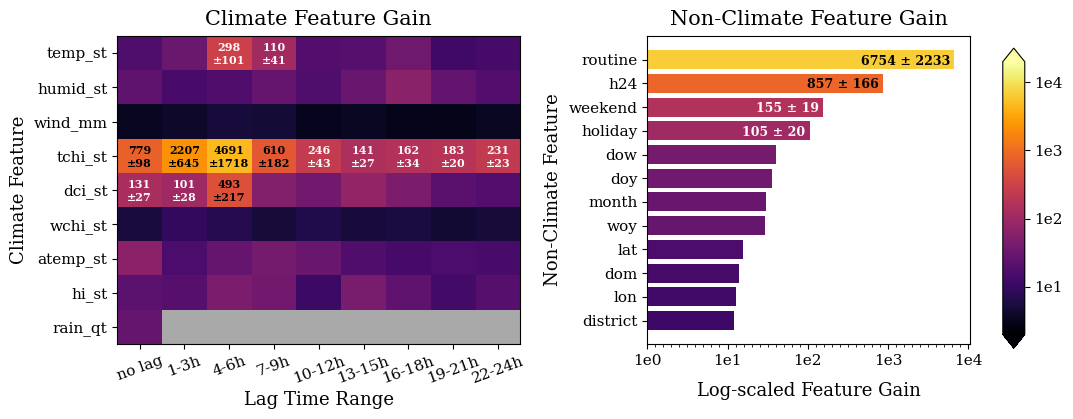

In [316]:
fig, axs = plt.subplots(1, 2, figsize=(11, 4), gridspec_kw={'width_ratios': [1, 0.8], 'wspace': 0.35})
fsize1 = 15
fsize2 = 13
fsize3 = 11
fsize4 = 9
fsize5 = 8

ax = axs[0]
# background color
ax.set_facecolor('darkgrey')
# Creating the plot with log10-scaled importance values
cax = ax.imshow(clim_importance_frame_log, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)

ax.set_xlabel('Lag Time Range', fontsize=fsize2)
ax.set_ylabel('Climate Feature', fontsize=fsize2)
ax.set_yticks(np.arange(len(climate_features)))
ax.set_yticklabels(climate_features, fontsize=fsize3)
ax.set_xticks(np.arange(len(lag_tag_name)))
ax.set_xticklabels(lag_tag_name, fontsize=fsize3, rotation=20)

ax.set_title('Climate Feature Gain', fontsize=fsize1, pad=8)

# find 3 most biggest values and annotate them
value_thres = 2.0
for i, feature in enumerate(climate_features):
    for j, tag in enumerate(lag_tag):
        log_importance = clim_importance_frame_log[i, j]
        if log_importance < value_thres or np.isnan(log_importance): continue
        std = clim_importance_std[i, j]
        textcolor = goodwhite if log_importance < 2.5 else 'black'
        ax.text(j, i+0.03, f'{int(10**log_importance)}\n±{int(std/1.732)}', \
                 ha='center', va='center', fontsize=fsize5, fontweight='bold', color=textcolor)

## ================== 2nd plot ================== ##
top_n = 30
ax = axs[1]

plot_feature_names = list(plot_target_mean_dict.keys())
plot_target = np.array(list(plot_target_mean_dict.values()))
plot_target_std = np.array(list(plot_target_std_dict.values()))

# Sorting the data by importance
sorted_indices = np.argsort(plot_target)[::-1]
sorted_feature_names = np.array(plot_feature_names)[sorted_indices]
sorted_plot_target = plot_target[sorted_indices]
sorted_plot_target_std = plot_target_std[sorted_indices]

# Selecting top_n features
top_feature_names = sorted_feature_names[:top_n]
top_plot_target = sorted_plot_target[:top_n]

# Transforming the importance values to a logarithmic scale
top_plot_target_log = np.log10(top_plot_target) 

# Creating the plot with log-scaled importance values
bars_log = ax.barh(top_feature_names, top_plot_target_log, color=cmap(norm(top_plot_target_log)))
ax.set_xlabel('Log-scaled Feature Gain', fontsize=fsize2, labelpad=10)
ax.set_ylabel('Non-Climate Feature', fontsize=fsize2, labelpad=5)
ax.invert_yaxis()  # Invert y-axis to show the highest importance at the top

# set x-axis ticks
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'1e{x:.0f}'))
# fontsize of xtick ytick
ax.tick_params(axis='both', which='major', labelsize=fsize3)
ax.set_title('Non-Climate Feature Gain', fontsize=fsize1, pad=8)

# anotate the top 2 features with their importance values, bold font
annotate_top_n = 4
for i, (feature, log_importance, std) in enumerate(zip(top_feature_names, top_plot_target_log, sorted_plot_target_std)):
    textcolor = goodwhite if log_importance < 2.5 else 'black'
    ax.text(log_importance - 0.05, i+0.07, f'{int(10**log_importance)} ± {int(std/1.732)}', \
            ha='right', va='center', fontsize=fsize4, fontweight='bold', color=textcolor)
    if i == annotate_top_n - 1:
        break

## ================== colorbar ================== ##
# Adding a color bar with log10-scaled values
"""
cbar = fig.colorbar(sm_log, ax=ax, orientation='vertical', label='Log10-scaled Importance', extend='both', pad=0.03)
cbar.ax.yaxis.label.set_fontsize(fsize2)
cbar.ax.yaxis.labelpad = 10
"""
cax = fig.add_axes([0.93, 0.10, 0.02, 0.75])
cbar = fig.colorbar(sm_log, cax=cax, orientation='vertical', extend='both')
# Set colorbar ticks to show actual values (untransformed)
log_ticks = [1,2,3,4]
cbar.set_ticks(log_ticks)
cbar.set_ticklabels([f'1e{tick}' for tick in log_ticks], fontsize=fsize3)

#fig.tight_layout()
fig.savefig(Path(figure_path, 'feature_importance_2.png'), dpi=600, bbox_inches='tight')

___